In [8]:
### This notebook compared the magic of Scrooge ensembles wrt the magic of eigenstates

import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy
import itertools
from scipy.special import psi, polygamma
import math

from scipy.linalg import sqrtm
from scipy.linalg import expm
from scipy.optimize import root_scalar

##Libraries in Toby's Code

import time
import operator
from functools import reduce

In [9]:
##We follow a subroutine of finding beta for each eigenstate, and then taking the gibbs state for that beta as the first moment.

#First, the basic definitions and functions
Paulis = ['I', 'X', 'Y', 'Z']
N = 12

c = N
str1 = ''
PauliOps=[]

def PauliStrings(N,c,str1):
    if c == 1:
        for k in range(len(Paulis)):
            PauliOps.append(str1 + Paulis[k])
    else:
        for k in range(len(Paulis)):
            PauliStrings(N,c-1,str1+Paulis[k])

PauliStrings(N,c,str1)

def PauliSpectrum(PauliOps, state):
    spec_vals = []
    for op in PauliOps:
        spec_vals.append(state.expectation_value(SparsePauliOp(op)))
    
    return spec_vals

#Now, we create the Hamiltonian

def Xp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'X'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Yp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Y'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Zp(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Z'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def ZZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'ZZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def YZp(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'YZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def hlist(N,J,h):
    h_list = [J]
    for i in range(1,N-1):
        h_list.append(h)
    h_list.append(-J)
    return h_list

def H_tfim(N,g,J,h_list):
    op = 0
    for i in range(1,N):
        op += g*Xp(i,N) + h_list[i-1]*Zp(i,N) + J*ZZp(i,N)
    op+=g*Xp(N,N) + h_list[N-1]*Zp(N,N)
    return op

def HaarState(N):
    coeffs = []
    for i in range(2**N):
        z = np.random.randn() + 1j * np.random.randn()
        coeffs.append(z)
    coeffs = np.array(coeffs)
    hst = Statevector(coeffs)/np.linalg.norm(coeffs)
    return hst

def FSE(q, spec,d):
    sum = 0
    if q == 0:
        return np.log2(d +1)
    elif q == 1:
        for i in range(1,len(spec)):
            if spec[i] == 0:
                sum+=0
            else:
                sum+=np.log2(np.abs(spec[i]))*(spec[i]**2)
        return -2*sum/(d-1)
    else:
        for i in range(1, len(spec)):
            sum += spec[i]**(2*q)
        sum/= (d-1)
        return np.log2(sum)/(1-q)

d = 2**N
J = 1
g = 1.1 #(np.sqrt(5) + 5)/8
h = 0.35
h_list = hlist(N,0.25,h)

H = H_tfim(N,g,J,h_list)



"""eigvals, eigvecs = np.linalg.eigh(H)

np.savetxt(f'Test_data/mfim_eigvecs_h={h},g={g},N={N}.txt',np.real(eigvecs))
np.savetxt(f'Test_data/mfim_eigvals_h={h},g={g},N={N}.txt',np.real(eigvals))"""




"eigvals, eigvecs = np.linalg.eigh(H)\n\nnp.savetxt(f'Test_data/mfim_eigvecs_h={h},g={g},N={N}.txt',np.real(eigvecs))\nnp.savetxt(f'Test_data/mfim_eigvals_h={h},g={g},N={N}.txt',np.real(eigvals))"

In [11]:
###Forming the subroutine, where \rho(\beta) = exp(-\beta H)/Z, and we solve for \beta in the equation Tr(\rho(\beta) H) = E_n, given E_n as a function parameter



def beta_solver_qiskit(E_n, H_mat):
    def f(beta):
        expH = expm(-beta * H_mat)
        rho = expH / np.trace(expH)
        return np.trace(H_mat @ rho).real - E_n

    beta = root_scalar(f, bracket=[0, 0.4], method='bisect')
    return beta.root

def beta_solver(E_n, H):
    """
    This function solves for beta in the equation Tr(rho(beta) H) = E_n,
    where rho(beta) = exp(-beta H)/Z
    """
    H_qobj = qt.Qobj(H) if not isinstance(H, qt.Qobj) else H

    def f(beta):
        try:
            rho = (-(beta * H_qobj)).expm()
            rho = rho / rho.tr()
            exp_val = expect(H_qobj, rho)
            print(f"beta = {beta}, ⟨H⟩ = {exp_val}")
            return exp_val - E_n
        except Exception as e:
            print(f"Error at beta = {beta}: {e}")
            return np.nan  # Force root_scalar to fail here

    beta = root_scalar(f, bracket=[-0.1, 0.5], method='bisect',maxiter=30)
    return beta.root


"""energies = []
betas = np.linspace(0, 10, 10)
for b in betas:
    rho = expm(-b * SparsePauliOp.to_matrix(H))
    rho = rho / np.trace(rho)
    energies.append(np.trace(SparsePauliOp.to_matrix(H) @ rho).real)
plt.plot(betas, energies)
#plt.axhline(E_n, color='r')
plt.show()"""

"energies = []\nbetas = np.linspace(0, 10, 10)\nfor b in betas:\n    rho = expm(-b * SparsePauliOp.to_matrix(H))\n    rho = rho / np.trace(rho)\n    energies.append(np.trace(SparsePauliOp.to_matrix(H) @ rho).real)\nplt.plot(betas, energies)\n#plt.axhline(E_n, color='r')\nplt.show()"

In [14]:
##Forming the subroutine, where \rho(\beta) = exp(-\beta H)/Z, and we solve for \beta in the equation Tr(\rho(\beta) H) = E_n, where E_n is the energy of the n-th eigenstate from the middle of the spectrum towards the ground state.

eigvals = np.loadtxt(f'Test_data/mfim_eigvals_h={h},g={g},N={N}.txt')
eigvecs = np.loadtxt(f'Test_data/mfim_eigvecs_h={h},g={g},N={N}.txt')

gs_energy = eigvals[0]

H_shifted = SparsePauliOp.to_matrix(H - gs_energy*SparsePauliOp('I'*N))

index = np.argmin(np.abs(eigvals))  #Energy of the eigenstate closest to zero

num_eigs = 15 #int(d/4)  #Scales exponentially
step_size = 100

beta_list_ext = []
ft_eigvals = []

print('Index:',index)




Index: 2062


In [15]:
for i in range(10,num_eigs):

    print('Index i:',i)

    eigval = eigvals[index-i*step_size]
    eigval_shifted = eigval - gs_energy
    print("Eigval:",eigval)
    beta_list_ext.append(beta_solver(eigval_shifted,H_shifted))
    ft_eigvals.append(eigval)

print(beta_list_ext)
print(ft_eigvals)

Index i: 10
Eigval: -3.4475022215791684
beta = -0.1, ⟨H⟩ = 18.773340350747272
beta = 0.5, ⟨H⟩ = 5.6364542883034865
beta = 0.19999999999999998, ⟨H⟩ = 11.018028091878406
beta = 0.04999999999999999, ⟨H⟩ = 14.745483078611889
beta = 0.12499999999999999, ⟨H⟩ = 12.81686043950094
beta = 0.16249999999999998, ⟨H⟩ = 11.898428845599762
beta = 0.14375, ⟨H⟩ = 12.353201453553075
beta = 0.134375, ⟨H⟩ = 12.583962551343426
beta = 0.12968749999999998, ⟨H⟩ = 12.700149910534272
beta = 0.13203125, ⟨H⟩ = 12.641990136155982
beta = 0.13320312499999998, ⟨H⟩ = 12.61295973354286
beta = 0.13261718749999998, ⟨H⟩ = 12.627470793074938
beta = 0.13232421875, ⟨H⟩ = 12.63472943052234
beta = 0.132470703125, ⟨H⟩ = 12.631099853106765
beta = 0.1325439453125, ⟨H⟩ = 12.629285258396838
beta = 0.13250732421875, ⟨H⟩ = 12.630192539580746
beta = 0.132525634765625, ⟨H⟩ = 12.629738894946026
beta = 0.1325164794921875, ⟨H⟩ = 12.629965716252551
beta = 0.13251190185546874, ⟨H⟩ = 12.630079127663898
beta = 0.13250961303710937, ⟨H⟩ = 12.630

In [20]:
print('Beta list:', beta_list_ext)
print('FT eigvals:', ft_eigvals)

ft_eigvals = [-3.4475022215791684,-3.852406849207879,-4.277292967401397,-4.728462318593347,-5.207897932647549]

data_old = np.loadtxt(f"Test_data/beta_list_eigvals.txt")
beta_list = data_old[:, 0].tolist()
ft_eigvals_old = data_old[:, 1].tolist()
beta_list.extend(beta_list_ext)
ft_eigvals_old.extend(ft_eigvals)
data = np.column_stack((beta_list, ft_eigvals_old))
np.savetxt(f"Test_data/beta_list_eigvals_{num_eigs}_{step_size}.txt", data)


Beta list: [0.13250798135995867, 0.14898641798645257, 0.16659363377839326, 0.18568949624896045, 0.20649317987263202]
FT eigvals: None


In [10]:
##Now, we form a subroutine to get the Gibbs state for a given beta or essentially, the eigenstate.

def scrooge_ensemble(beta,N,H,M=100):
    rho = expm(-beta * SparsePauliOp.to_matrix(H))
    rho = rho / np.trace(rho)#Numpy array

    #convert to qiskit operators
    
    sqrt_rho = sqrtm(rho)
    rho_op = Operator(rho)

    #Form M random Haar states

    rand_states = []
    rand_states2 = []
    for i in range(M):
        rand_states.append(HaarState(N).data)
        rand_states2.append(HaarState(N))

    #Forming the Scrooge ensemble
    fin_states = [(np.dot(sqrt_rho,rand_state))/np.linalg.norm(np.dot(sqrt_rho,rand_state)) for rand_state in rand_states]
    print(fin_states[0].shape)
    #fin_states = [state.data[0] for state in fin_states]  # Convert to numpy arrays
    prob_list = [np.real(rand_state.expectation_value(rho_op)) for rand_state in rand_states2]

    prob_list_normalised = [p/np.sum(prob_list) for p in prob_list]
    return fin_states, prob_list_normalised
        


In [11]:
#Test scrooge ensemble

test_states, test_probs = scrooge_ensemble(0.1,N,H,M=10)

(4096,)


In [28]:
print(np.linalg.norm(test_states[0]))
print(len(test_states))
print(len(test_states[2]))

0.9999999999999999
10
4096


In [27]:
#Let us compute the magic...

haar_state = HaarState(N)
haar_state1 = haar_state.data  # Convert to numpy array
haar_state2 = haar_state.data[0]

print(haar_state1[0])
#print(haar_state2.shape)

(0.0014191873057717035+0.0013163926786286314j)


In [6]:
del test_states
del test_probs

In [ ]:
##Let us copy the efficient PAuli sampling subroutine from Toby's code here

n_qubits=N
max_qubit=min((n_qubits-4)//2,12) 


do_bell_sampling=False ##whether to sample from Pauli distribution or Bell distribution

#tensors operators together 
def genFockOp(op,position,size,levels=2,opdim=0):
    opList=[qt.qeye(levels) for x in range(size-opdim)]
    opList[position]=op
    return qt.tensor(opList)


def numberToBase(n, b,n_qubits):
    if n == 0:
        return np.zeros(n_qubits,dtype=int)
    digits = np.zeros(n_qubits,dtype=int)
    counter=0
    while n:
        digits[counter]=int(n % b)
        n //= b
        counter+=1
    return digits[::-1]


    
def get_all_paulis_N(n_qubits):
    ##get all pauli operators
    n_paulis=4**n_qubits

    pauli_list=np.zeros([n_paulis,n_qubits],dtype=int)
    for k in range(n_paulis):
        pauli_list[k,:]=numberToBase(k,4,n_qubits)

    levels=2
    opZ=[genFockOp(qt.sigmaz(),i,n_qubits,levels) for i in range(n_qubits)]
    opX=[genFockOp(qt.sigmax(),i,n_qubits,levels) for i in range(n_qubits)]
    opY=[genFockOp(qt.sigmay(),i,n_qubits,levels) for i in range(n_qubits)]

    
    opId=genFockOp(qt.qeye(levels),0,n_qubits)

    pauli_op_list=[]
    for k in range(n_paulis):
        pauli_string=pauli_list[k]
        pauli=opId
        for i in range(n_qubits):
            if(pauli_string[i]==1):
                pauli=opX[i]*pauli
            elif(pauli_string[i]==2):
                pauli=opY[i]*pauli
            elif(pauli_string[i]==3):
                pauli=opZ[i]*pauli
                
        pauli_op_list.append(pauli)
    return pauli_op_list,pauli_list





def get_conversion_matrix_mod_add_index(base_states):
    ##precompuation for computing renyi stabilizer entropy
    n_qubits=len(base_states[0])
    mag = len(base_states)
    to_index=2**np.arange(n_qubits)[::-1]
    conversion_matrix=np.zeros([mag,mag],dtype=int)
    for j_count in range(mag):
        base_j=base_states[j_count]
        k_plus_j=np.mod(base_states+base_j,2)
        k_plus_j_index=np.sum(k_plus_j*to_index,axis=1)
        conversion_matrix[j_count,:]=k_plus_j_index

    return conversion_matrix

def get_conversion_matrix_binary_prod(base_states):
    ##precompuation for computing renyi stabilizer entropy
    mag = len(base_states)
    conversion_matrix=np.zeros([mag,mag],dtype=int)
    
        
    for i_count in range(mag):
        base_i=base_states[i_count]
        binary_product=np.mod(np.dot(base_states,base_i),2)
        conversion_matrix[i_count,:]=(-1)**binary_product
        

    return conversion_matrix

def renyi_entropy_fast(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=[2]):
    ##fast code to compute renyi entropy which uses numpy to full extent
    #requires precomputation with get_conversion_matrix_binary_prod and get_conversion_matrix_mod_add_index
    coeffs=state.data.toarray()[:,0]
    n_qubits=len(state.dims[0])

       
    subtract_log=n_qubits*np.log(2)
    
    prob_list_full=np.abs(np.dot(np.conjugate(coeffs)*conversion_matrix_binary_prod, coeffs[conversion_matrix_mod_add_index] ))**2
    
    #print(prob_list_full)
    epsilon_cutoff=10**-30
    prob_list=2**(-n_qubits)*prob_list_full[prob_list_full>epsilon_cutoff]
    

    renyi_fast_list=[]
    for alpha_p in alpha:
        if(alpha_p==1): ##shannon magic
            renyi_fast= -np.sum(prob_list*np.log(prob_list))-subtract_log
        else:
        

            renyi_fast = 1/(1-alpha_p)*np.log(np.sum(prob_list**(alpha_p)))-subtract_log

        renyi_fast_list.append(renyi_fast)
        
    magic_capacity=np.sum(prob_list*(-np.log(prob_list)-subtract_log)**2)-renyi_fast**2
            
        
        
    return renyi_fast_list,magic_capacity


def project_first_qubit(state):
    """
    measures first qubit of state 
    in computational basis and returns
    normalized projected state for each outcome
    and associated probabilitites
    
    """
    
    n_qubits=len(state.dims[0])

    n_qubits_remain=n_qubits-1

    if(n_qubits>1):
        dims_vec_remain=[[2]*(n_qubits_remain),[1]*(n_qubits_remain)]
    else:
        dims_vec_remain=[[1],[1]]
    amplitudes=state.data.toarray()[:,0]
    amplitudes0=amplitudes[:2**n_qubits_remain]
    amplitudes1=amplitudes[2**n_qubits_remain:]

    proj_prob0=np.sum(np.abs(amplitudes0)**2)
    proj_prob1=np.sum(np.abs(amplitudes1)**2)

    if(proj_prob0>0):
        proj_state0=qt.Qobj(amplitudes0/np.sqrt(proj_prob0),dims=dims_vec_remain)
    else:
        proj_state0=qt.Qobj(amplitudes0,dims=dims_vec_remain)
    
    if(proj_prob1>0):
        proj_state1=qt.Qobj(amplitudes1/np.sqrt(proj_prob1),dims=dims_vec_remain)
    else:
        proj_state1=qt.Qobj(amplitudes1,dims=dims_vec_remain)

    return proj_state0,proj_state1,proj_prob0,proj_prob1





def get_overlaps(state,max_qubit):
    """
    computes needed overlaps E for Von Neumann SE sampling in Feynmann trajectories
    Input:
        state 
        max_qubit, which is maximal number of projected qubits to compute overlaps for

    
    Output:
        overlaps_list: Overlaps computed
        probs_projected: Probability of projection
        states_projected: normalized state after projection
        
    """


    n_qubits=len(state.dims[0])

    
    overlaps_list=[]
    
    ##initial stuff
    states_projected=[state] ##start with initial state
    probs_projected=[1]

    ##go through qubits up to max_qubit, where we stop
    for order in range(n_qubits):
    
        n_qubits_left=len(states_projected[0].dims[0])
        
        if(n_qubits_left<=max_qubit):
            break
        else:
            new_states_projected=[]
            new_probs_projected=[]

            ##projet one additional qubit and add them to the list of projected states
            for k in range(len(states_projected)):
                curr_state=states_projected[k]
                curr_prob=probs_projected[k]
                
                ##sample left-most qubit
                proj_state0,proj_state1,proj_prob0,proj_prob1=project_first_qubit(curr_state)
        
                    
                new_states_projected.append(proj_state0)
                new_states_projected.append(proj_state1)
                new_probs_projected.append(curr_prob*proj_prob0)
                new_probs_projected.append(curr_prob*proj_prob1)



            states_projected=new_states_projected
            probs_projected=np.array(new_probs_projected)
            n_states=len(new_states_projected)
            

            overlaps=np.ones([n_states,n_states],dtype=np.complex128)
            
            states_array=np.array(states_projected)[:,:,0]
            ##compute overlaps between projected states
            for q in range(len(states_projected)):
                overlaps[:,q]=np.sqrt(probs_projected*probs_projected[q])*np.dot(states_array,np.conj(states_array[q]))
                
            overlaps_list.append(overlaps)



    return overlaps_list,probs_projected,states_projected



def sample_Pauli(state,max_qubit,rng,overlaps_list,probs_projected,states_projected,do_bell_sampling=False):
    """
    Performs Pauli sampling P \sim <psi|P|psi>^2
    
    Set do_bell_sampling=True to do Bell sampling instead which is P \sim <psi^*|P|psi>^2
    
    Main issue is that Pauli sampling requires too large memory to be done directly
    
    Thus, first performs Feynman like trajectory sampling which requires less memory
    then after projecting sufficient qubits
    switches to direct sampling from tensored state
    
    """
    
    n_qubits=len(state.dims[0])


    ##how bell transform is changing computational basis state 00, 01,10,11 
    ##first index: bell outcome, second index: components for that state, third index: which states are used from first and second copy
    bell_transform=np.array([[[0,0],[1,1]],[[0,1],[1,0]],[[0,0],[1,1]],[[0,1],[1,0]]],dtype=int) 
    bell_factor=1/np.sqrt(2)*np.array([[1,1],[1,1],[1,-1],[1,-1]]) ##amplitude factors
    
    

    bell_description1=[[]]
    bell_description2=[[]]
    bell_description_factor=[1]
       
    
    ##more than 12 is bad due to memory
    #max_qubit=min((n_qubits-4)//2,12) ##when to switch to constructing full vector
    
    prod_probs=1 ##initial probability
    log_prod_probs=0 ##logarithmic version due to floating point errors possible for high N
    bell_outcome=[] ##collect outcomes for bell sampling

    for order in range(n_qubits):
        ##go through qubits
        n_qubits_left=n_qubits-order
        
        if(n_qubits_left<=max_qubit):
            ##here we switch to direct sampling from full state


            if(len(bell_description_factor)==1):
                ##directly construct state if no trajectories have been done
                if(do_bell_sampling==False):##Pauli sampling
                    tensor_state=qt.tensor([state.conj(),state])
                else: ##Bell sampling
                    tensor_state=qt.tensor([state,state])
            else:
                ##construct full state from trajectories
                index_states=(2**np.arange(order))[::-1]
                tensor_state=0
                for k in range(len(bell_description1)):
                    ##go through superposition state which was generated
                    #print(k)
                    index1=sum(bell_description1[k]*index_states)
                    index2=sum(bell_description2[k]*index_states)
                    if(do_bell_sampling==False):##Pauli sampling
                        tensor_state+=bell_description_factor[k]*np.sqrt(probs_projected[index1])*np.sqrt(probs_projected[index2])*qt.tensor([states_projected[index1].conj(),states_projected[index2]])
                    else: ##Bell sampling
                        tensor_state+=bell_description_factor[k]*np.sqrt(probs_projected[index1])*np.sqrt(probs_projected[index2])*qt.tensor([states_projected[index1],states_projected[index2]])

            ##marginal sampling from full state
            
            hadamard_gate=qt.qip.operations.hadamard_transform(1)
            for i in range(n_qubits_left):
                ##go throuhg qubits left
                #print(i)
                n_qubits_now=n_qubits_left-i
                #print("Projecting on full state with remaining",n_qubits_now)
    
                
                ##permute order of qubits such that first qubit of each copy is next to each other at front
                tensor_state=tensor_state.permute([0,n_qubits_now]+list(np.arange(1,n_qubits_now))+list(np.arange(n_qubits_now+1,2*n_qubits_now)))
    
                ##perform Bell transformation
                tensor_state=qt.qip.operations.gate_expand_1toN(hadamard_gate, 2*n_qubits_now, 0)*qt.qip.operations.cnot(2*n_qubits_now,0,1)*tensor_state
                
                ##get projection of first qubit from Bell pair
                proj_state0,proj_state1,proj_prob0,proj_prob1=project_first_qubit(tensor_state)
    
                ##sample by computing probabilities of projection of each qubit
                ###and sampling from probabilities
                rand_val=rng.random()
                bell_index=0
                bell_prob=1
                if(proj_prob0>rand_val):
                    bell_prob*=proj_prob0
                    bell_index+=0
                    tensor_state=proj_state0
                else:
                    bell_prob*=proj_prob1
                    bell_index+=2
                    tensor_state=proj_state1
            
                ##second qubit of Bell pair
                proj_state0,proj_state1,proj_prob0,proj_prob1=project_first_qubit(tensor_state)
            
                rand_val=rng.random()
                if(proj_prob0>rand_val):
                    bell_prob*=proj_prob0
                    bell_index+=0
                    tensor_state=proj_state0
                else:
                    bell_prob*=proj_prob1
                    bell_index+=1
                    tensor_state=proj_state1
                
                bell_outcome.append(bell_index)
                prod_probs*=bell_prob
                log_prod_probs+=np.log(bell_prob)
                

            break #finished
                
        else:

            ##Feynman-like sampling from trajectories

            ##this is list of overlaps we already pre-computed
            overlaps=overlaps_list[order]
            
            ##numerates all possible states
            index_states=(2**np.arange(order+1))[::-1]
            

            sum_bell_prob=0
            
            rand_val=rng.random() ##sample random number for sampling
            
            ##compute probabilities of all bell states and sample
            for bell_index in range(4):
                ##is a description of trajectory of sampled outcomes
                ##new_bell_description1 describes first copy in tensor product
                ##new_bell_description2 describes second copy in tensor product
                new_bell_description1=[]
                new_bell_description2=[]
                
                bell_state_index1=np.zeros(2*len(bell_description_factor),dtype=int)
                bell_state_index2=np.zeros(2*len(bell_description_factor),dtype=int)
                new_bell_description_factor=[]
                
                ##go through all already projected states, and append new ones
                for k in range(len(bell_description_factor)):
                    ##first state
                    new_bell_description1.append(bell_description1[k]+[bell_transform[bell_index][0][0]]) ##first copy
                    new_bell_description2.append(bell_description2[k]+[bell_transform[bell_index][0][1]]) ##second copy
                    
                    bell_state_index1[2*k]=sum(new_bell_description1[2*k]*index_states)
                    bell_state_index2[2*k]=sum(new_bell_description2[2*k]*index_states)
    
                    ##second state
                    new_bell_description1.append(bell_description1[k]+[bell_transform[bell_index][1][0]]) ##first copy
                    new_bell_description2.append(bell_description2[k]+[bell_transform[bell_index][1][1]]) ##second copy
                    
                    bell_state_index1[2*k+1]=sum(new_bell_description1[2*k+1]*index_states)
                    bell_state_index2[2*k+1]=sum(new_bell_description2[2*k+1]*index_states)
                    
                    
                    new_bell_description_factor.append(bell_description_factor[k]*bell_factor[bell_index][0])
                    new_bell_description_factor.append(bell_description_factor[k]*bell_factor[bell_index][1])
                    
                    
                ##probability of sampling this outcome
                bell_prob=0
                ##get probability by going through all superposition states
                new_bell_description_factor=np.array(new_bell_description_factor)
                for k in range(len(new_bell_description_factor)):
                    if(do_bell_sampling==False):##Pauli sampling
                        bell_prob+=np.sum(new_bell_description_factor[k]*new_bell_description_factor*np.conjugate(overlaps[bell_state_index1[k],bell_state_index1])*overlaps[bell_state_index2[k],bell_state_index2])
                    else:
                        bell_prob+=np.sum(new_bell_description_factor[k]*new_bell_description_factor*overlaps[bell_state_index1[k],bell_state_index1]*overlaps[bell_state_index2[k],bell_state_index2])


                #print(bell_prob)
                bell_prob=np.real(bell_prob)
                sum_bell_prob+=bell_prob ##keep track of probabilities from previous outcomes

            
                if(sum_bell_prob>rand_val):
                    
                    ##select this path going forward
                    
                    ##keep description of states which were sampled
                    bell_description1=new_bell_description1
                    bell_description2=new_bell_description2
                    ##stores renormalization with sampling probability
                    bell_description_factor=np.array(new_bell_description_factor)/np.sqrt(bell_prob)
                    

                    ##store outcome and probabilities
                    bell_outcome.append(bell_index)
                    prod_probs*=bell_prob
                    log_prod_probs+=np.log(bell_prob)
        
                    break
        
                if(bell_index>=3):
                    ##check if something went wrong
                    raise NameError("Added Probabilities smaller than 1")
        
        
    map_outcome_pauli=np.array([0,1,3,2],dtype=int) ##map bell outcome to pauli operator
    
    ##expectation value of sampled pauli
    expect_pauli_sq=2**(n_qubits)*prod_probs ## is expectation value of pauli **2
    
    ##collect paulis sampled
    pauli_outcome=[map_outcome_pauli[bell_outcome[i]] for i in range(n_qubits)]

    return expect_pauli_sq,pauli_outcome

def pauli_spectrum_sampled(state,max_qubit,n_sample = 10**3,do_bell_sampling=False):

    rng=np.random.default_rng()

    #dims_vec=[[2]*n_qubits,[1]*n_qubits]
    #dims_mat=[[2]*n_qubits,[2]*n_qubits]

    print("start")

    expect_pauli_sq_list=[]

    print("Getting overlaps")
    ##precompute overlaps needed for Von Neumann sampling
    overlaps_list,probs_projected,states_projected=get_overlaps(state,max_qubit)
    print("Got overlaps")

    sampling_time=time.time()
    print("Start sampling")
    percent=n_sample//10
    for step in range(n_sample):
        if(percent>0):
            if((step+1)%percent==0):
                print("Done",step//percent*10,"%")

        expect_pauli_sq,pauli_outcome=sample_Pauli(state,max_qubit,rng,overlaps_list,probs_projected,states_projected,do_bell_sampling=do_bell_sampling)
        expect_pauli_sq_list.append(expect_pauli_sq)

        

    print("Finished sampling")
    expect_pauli_sq_list=np.array(expect_pauli_sq_list)
    print("Sampling time",time.time()-sampling_time)

    return expect_pauli_sq_list

def pauli_spectrum_exact(state):
    pauli_op_list,pauli_list=get_all_paulis_N(n_qubits)
    pauli_sq_expect_exact=np.array([qt.expect(pauli_op_list[k],state)**2 for k in range(len(pauli_op_list))])

    return pauli_sq_expect_exact

def pauli_spectrum_fast(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod):
    ##fast code to compute renyi entropy which uses numpy to full extent
    #requires precomputation with get_conversion_matrix_binary_prod and get_conversion_matrix_mod_add_index
    coeffs=state  #.data.toarray()[:,0]
    n_qubits = int(np.log2(len(coeffs)))
    
    prob_list_full=np.abs(np.dot(np.conjugate(coeffs)*conversion_matrix_binary_prod, coeffs[conversion_matrix_mod_add_index] ))
    
    #print(prob_list_full)
    epsilon_cutoff=10**-15
    prob_list=2**(-n_qubits)*prob_list_full[prob_list_full>epsilon_cutoff]

    return prob_list

def pauli_spectrum_fast2(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod):
    ##fast code to compute renyi entropy which uses numpy to full extent
    #requires precomputation with get_conversion_matrix_binary_prod and get_conversion_matrix_mod_add_index
    coeffs=state  #.data.toarray()[:,0]
    n_qubits = int(np.log2(len(coeffs)))
    
    prob_list_full=np.abs(np.dot(np.conjugate(coeffs)*conversion_matrix_binary_prod, coeffs[conversion_matrix_mod_add_index] ))**2
    
    #print(prob_list_full)
    epsilon_cutoff=10**-30
    prob_list=2**(-n_qubits)*prob_list_full[prob_list_full>epsilon_cutoff]

    return prob_list




<>:239: SyntaxWarning: invalid escape sequence '\s'
<>:239: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ys/hsq5k3zs70b8y915g7tk_yx00000gn/T/ipykernel_2188/854141511.py:239: SyntaxWarning: invalid escape sequence '\s'
  """


In [ ]:
#Let us check how long it takes to compute exact spectrum for 12 qubits...

eigvecs = np.loadtxt(f'Test_data/mfim_eigvecs_h={h},g={g},N={N}.txt')


start=time.time()

base_states=np.array([numberToBase(i, 2,n_qubits) for i in range(2**n_qubits)],dtype=int)

##these steps need only be run once
print("Get magic bases")
conversion_matrix_binary_prod=get_conversion_matrix_binary_prod(base_states)
print("Get mod add base")
conversion_matrix_mod_add_index=get_conversion_matrix_mod_add_index(base_states)
print("Finish magic bases")

print("Exact setup time",time.time()-start)


Get magic bases
Get mod add base
Finish magic bases
Exact setup time 0.7233850955963135


In [32]:

start=time.time()
example_state = eigvecs[:,2062]

ps_exact = pauli_spectrum_fast(example_state,conversion_matrix_binary_prod,conversion_matrix_mod_add_index)

print("Exact time",time.time()-start)
print("Exact spectrum",ps_exact)
print("spectrum log",np.log(ps_exact))
print(len(ps_exact))

print(-np.sum(ps_exact*np.log(ps_exact)))

##Pretty damn fast, to say the least...

Exact time 0.5068960189819336
Exact spectrum [4.05943775e-06 3.57075336e-04 1.02983233e-03 ... 1.72336825e-03
 1.71262966e-03 5.34949629e-04]
spectrum log [-12.41446608  -7.93756377  -6.87835927 ...  -6.36347462  -6.36972528
  -7.53333797]
16777216
224896.4790297786


In [36]:
##Now, we can get the magic using the exact fast pasuli_spectrum methods

def get_magic_exact(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=[2]):
    """
    Computes magic of state using fast pauli spectrum method
    """
    
    prob_list=pauli_spectrum_fast2(state,conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=[alpha])
    renyi_fast_list=[]

    n_qubits = int(np.log2(len(state)))
    d = 2**n_qubits


    print("Number of qubits:", n_qubits)
    print("Dimension:", d)

    for alpha_p in alpha:
        if(alpha_p==1):
            renyi_fast= (-np.sum(prob_list*np.log2(prob_list)) - n_qubits)*(d/(d-1))  #-n_qubits*np.log(2)


    
        else:
        

            renyi_fast = 1/(1-alpha_p)*(np.log2(np.sum(prob_list**(alpha_p)) - 1/d**alpha_p) + alpha_p*np.log2(d) - np.log2(d-1) ) #-n_qubits*np.log(2)

        renyi_fast_list.append(renyi_fast)
    
    
    
    return renyi_fast_list



In [38]:
##Let us now compute magic of these eigenstates and store them in a proper array structure of dims (num_alphas, num_betas)
index = 2062
num_samples = 10
step_size = 100
num_alphas = 4

scrooge_samples = 10

alpha_list = [0.5,1,2,3]

beta_list = np.loadtxt("Test_data/beta_list_eigvals.txt")[:,0]

"""magic_eig = np.zeros((num_alphas,num_samples))
print("Eigenstate magic")

for i in range(num_samples):
    print("i:",i)
    eigvec = eigvecs[:,index-i*step_size]
    magic_list = get_magic_exact(eigvec,conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=alpha_list)

    for j in range(num_alphas):
        magic_eig[j,i] = magic_list[j]
np.savetxt(f"Test_data/magic_eig_{num_samples}.txt",magic_eig)"""

#Now, we do the same for the scrooge ensemble after summing over the eigenstates with probabilities


"""print("Scrooge magic test")

for i in range(scrooge_samples):
        magic_list = test_probs[i]*get_magic_exact(test_states[i],conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=alpha_list)
        for j in range(num_alphas):
            magic_list_fin[j] += magic_list[j]

print("Magic computed")"""

magic_list_fin = [0]*num_alphas

magic_scrooge = np.zeros((num_alphas,num_samples))
k=0
for beta in beta_list:
    states, prob_list = scrooge_ensemble(beta,N,H,M=scrooge_samples)
    print("Scrooge ensemble for beta",beta)
    magic_list_fin = [0]*num_alphas
    for i in range(scrooge_samples):
        magic_list = get_magic_exact(states[i],conversion_matrix_mod_add_index,conversion_matrix_binary_prod,alpha=alpha_list)
        for j in range(num_alphas):
            magic_list_fin[j] += prob_list[i]*magic_list[j]

    print("Magic computed")

    print(magic_list_fin)

    
    
    for j in range(num_alphas):
             magic_scrooge[j,k] = magic_list_fin[j]

    k+=1
np.savetxt(f"Test_data/magic_scrooge_{scrooge_samples}.txt",magic_scrooge)


(4096,)
Scrooge ensemble for beta -5.507366731763441e-05
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Magic computed
[np.float64(11.34901813602903), np.float64(10.948014356025036), np.float64(10.41600140086826), np.float64(10.047828669932187)]
(4096,)
Scrooge ensemble for beta 0.011759553197771305
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Number of qubits: 12
Dimension: 4096
Magic 

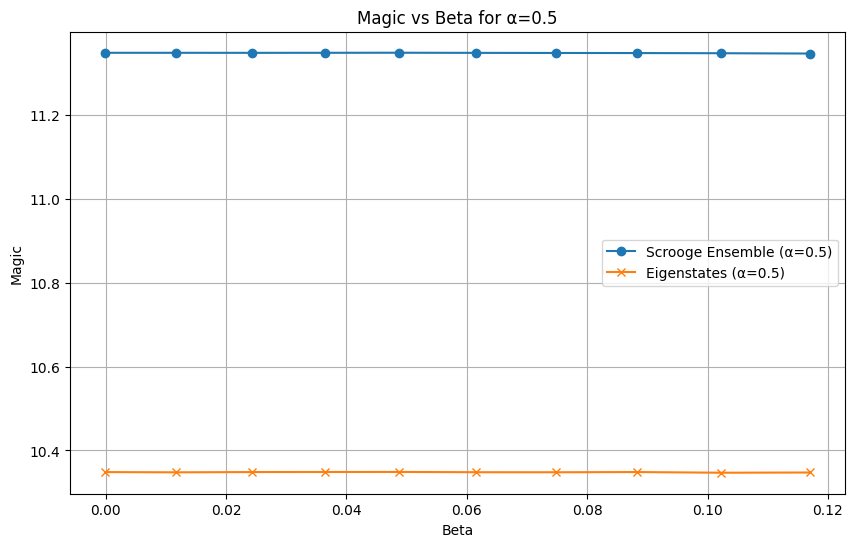

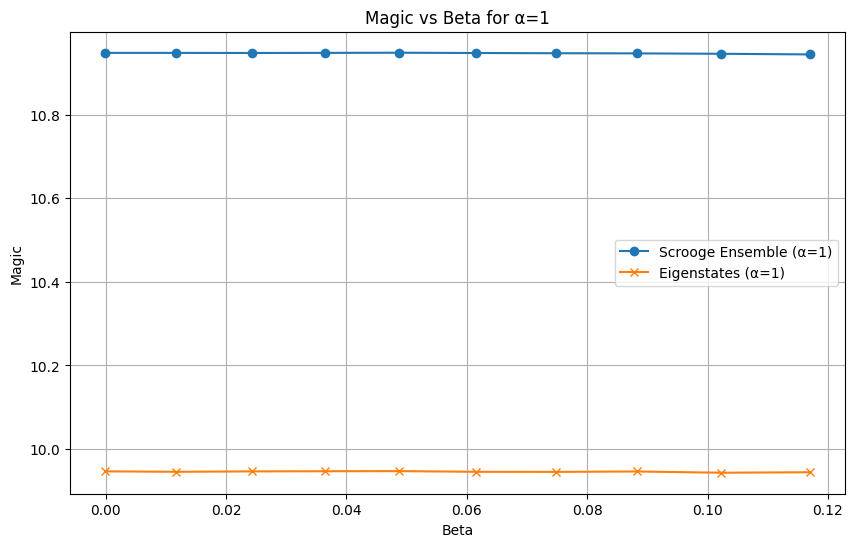

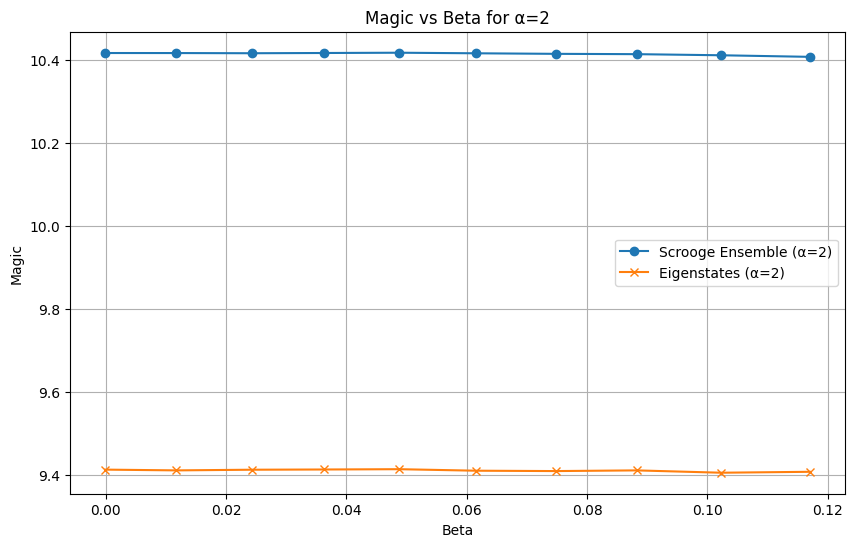

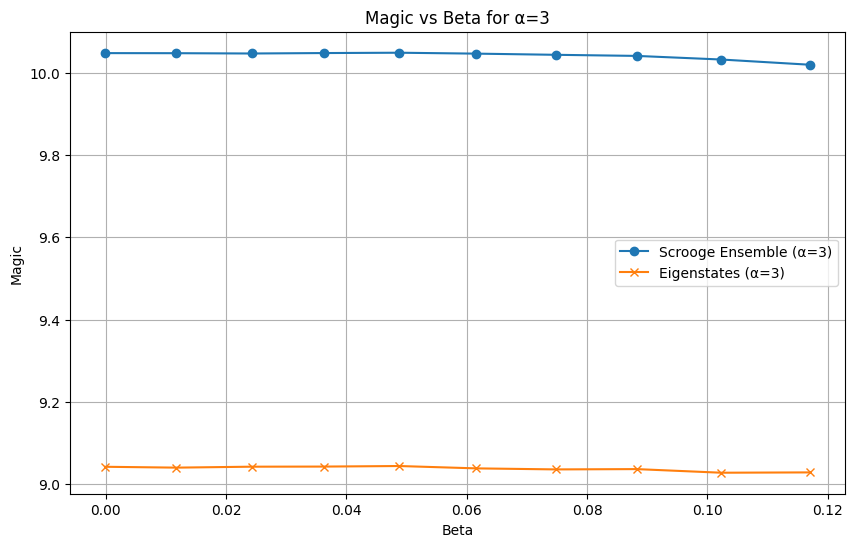

[10.34832017 10.34775492 10.34836628 10.34856193 10.34866251 10.34799798
 10.34789856 10.34839019 10.34679885 10.34733179]


In [7]:
##Let us plot the magic v/s beta of the scrooge ensemble and eigenstates for each alpha

#Load the magic data for eigenstates
magic_eig = np.loadtxt("Test_data/magic_eig_10.txt")
magic_scrooge = np.loadtxt("Test_data/magic_scrooge_10.txt")

beta_list = np.loadtxt("Test_data/beta_list_eigvals.txt")[:,0]
alpha_list = [0.5, 1, 2, 3]  # Corresponding to the alphas used in the magic calculations

num_alphas = 4

for j in range(num_alphas):
    plt.figure(figsize=(10, 6))
    plt.plot(beta_list, magic_scrooge[j], label=f'Scrooge Ensemble (α={alpha_list[j]})', marker='o')
    plt.plot(beta_list, magic_eig[j], label=f'Eigenstates (α={alpha_list[j]})', marker='x')
    plt.xlabel('Beta')
    plt.ylabel('Magic')
    plt.title(f'Magic vs Beta for α={alpha_list[j]}')
    plt.legend()
    plt.grid()
    plt.savefig(f'Test_data/magic_vs_beta_alpha_{alpha_list[j]}.png')
    plt.show()


print(magic_eig[0])





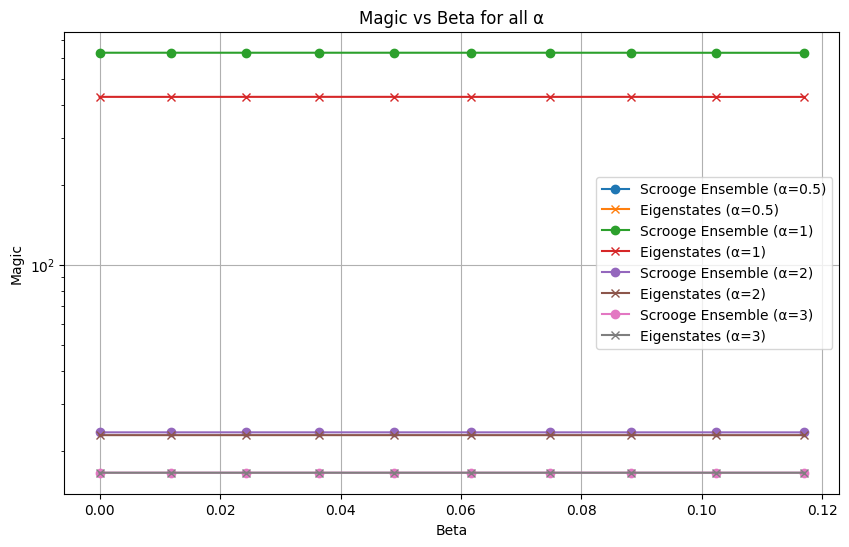

In [13]:
#Now, plot for all alphas together
plt.figure(figsize=(10, 6))
for j in range(num_alphas):
    plt.plot(beta_list, magic_scrooge[j], label=f'Scrooge Ensemble (α={alpha_list[j]})', marker='o')
    plt.plot(beta_list, magic_eig[j], label=f'Eigenstates (α={alpha_list[j]})', marker='x')
plt.xlabel('Beta')
plt.ylabel('Magic')
plt.yscale('log')
plt.title('Magic vs Beta for all α')
plt.legend()
plt.grid()
plt.savefig('Test_data/magic_vs_beta_all_alphas.png')


In [ ]:
##Next part, we fix a beta (choose a random mid-spectrum eigenstate, and find it's beta) and plot the magic for different N